In [90]:
%matplotlib inline
import os
from matplotlib import pylab
import sys
from os.path import dirname
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','2_hillslope_discharge'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','1_data_preparation'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','3_channel_routing'))

from vadoseZone import *
from groundwaterZone import *
from REW import REW
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from datetime import date
import pandas as pd
import numpy as np
import time
import sys

from prep import rew_params
rew_params()

In [91]:
# Load config, parameter, and forcing files

parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir, 'StreamflowTempModel', '1_data_preparation'))
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
climate_group_forcing = pickle.load( open( os.path.join(parent_dir,'model_data','climate_group_forcing.p'), "rb" ) )
parameter_group_params = pickle.load( open( os.path.join(parent_dir,'model_data','parameter_group_params.p'), "rb" ))
model_config = pickle.load( open( os.path.join(parent_dir, 'model_data', 'model_config.p'), 'rb'))


In [92]:
start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
dt = model_config['dt_hillslope']
t = model_config['t_hillslope']
resample_freq_hillslope = model_config['resample_freq_hillslope']
timestamps_hillslope = model_config['timestamps_hillslope']

In [93]:
Z = [ 200, 250, 300, 350, 400, 450]
solved_hillslopes = {}
for frac in Z: 
    parameter_group_params[1]['zrR'] = frac
    group_ids = [rew_config[i]['group'] for i in rew_config.keys()]
    solved_group_hillslopes_dict = {}

    for group_id in group_ids:

        parameter_group_id = group_id[0]
        climate_group_id = group_id[1]

        vz = parameter_group_params[parameter_group_id]['vz'](**parameter_group_params[parameter_group_id])
        gz = parameter_group_params[parameter_group_id]['gz'](**parameter_group_params[parameter_group_id])    

        rew = REW(vz, gz,  **{'pet':climate_group_forcing[climate_group_id].pet, 'ppt':climate_group_forcing[climate_group_id].ppt, 'aspect':90})

        storageVZ       = np.zeros(np.size(t))
        storageGZ       = np.zeros(np.size(t))
        discharge       = np.zeros(np.size(t))
        leakage         = np.zeros(np.size(t))
        ET              = np.zeros(np.size(t))
        ETR              = np.zeros(np.size(t))
        ETS              = np.zeros(np.size(t))
        overlandFlow    = np.zeros(np.size(t))

        # Resample pet and ppt to integration timestep
        ppt = np.array(rew.ppt[start_date:stop_date].resample(resample_freq_hillslope).ffill())
        pet = np.array(rew.pet[start_date:stop_date].resample(resample_freq_hillslope).ffill())

        # Solve group hillslope
        for i in range(len(t)):
            rew.vz.update(dt,**{'ppt':ppt[i],'pet':pet[i]})
            storageVZ[i] = rew.vz.storageVZ
            leakage[i]      = rew.vz.leakage
            ET[i]           = rew.vz.ET
            rew.gz.update(dt,**{'leakage':leakage[i]})
            storageGZ[i] = rew.gz.storageGZ
            discharge[i] = rew.gz.discharge
            overlandFlow[i] = rew.vz.overlandFlow + rew.gz.overlandFlow
            try: 
                ETR[i] = rew.vz.ETR
                ETS[i] = rew.vz.ETS
            except:
                continue


        # Save all results as daily data. 
        solved_hillslope = pd.DataFrame({'storageGZ':storageGZ, 'leakage':leakage, 'ET':ET, 'storageVZ':storageVZ, 'discharge':discharge, 'overlandFlow':overlandFlow, 'ETR':ETR, 'ETS':ETS, 'ppt':ppt}, index=timestamps_hillslope)
        solved_hillslope = solved_hillslope.loc['1-2012':'4-2012']
        solved_hillslopes[frac] = solved_hillslope.resample('D').mean()



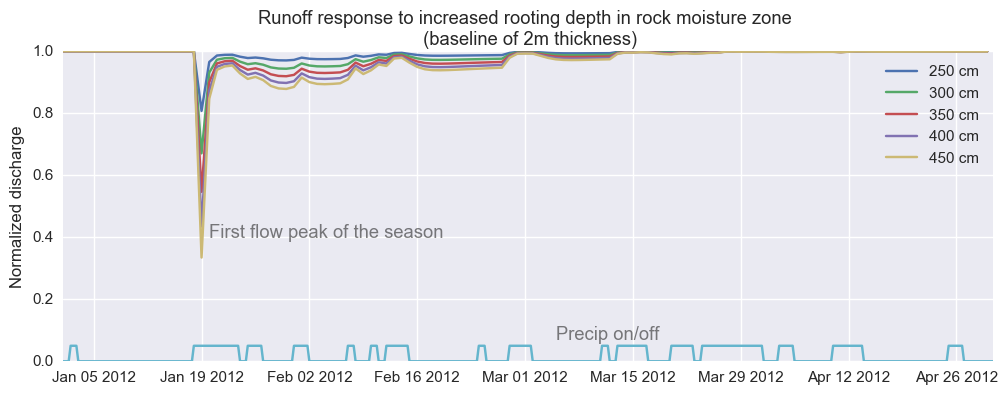

In [95]:
sns.set(font_scale=1.1)
plt.figure(figsize=(12,4))
legendstr = [str(Z[i])+' cm' for i in range(1,len(Z))]
for frac in Z[1:]:
    ax = plt.plot(solved_hillslopes[frac]['discharge']/solved_hillslopes[200]['discharge'])
# plt.yscale('log')
plt.legend(legendstr)
plt.plot((solved_hillslope['ppt']>0)*.05)
plt.title('Runoff response to increased rooting depth in rock moisture zone \n (baseline of 2m thickness)')
plt.ylabel('Normalized discharge')
plt.annotate('First flow peak of the season', ('1-20-2012', .4), alpha=.6)
plt.annotate('Precip on/off', ('3-05-2012', .07), alpha=.6)
plt.savefig('/Users/daviddralle/Desktop/doug_fircation.pdf')